# Tarea 4, Parte 2. RUNet para SuperResolución

Aprendizaje de Máquina I, 2020

Oscar Esaú Peralta Rosales

Maestría en Ciencias con Especialidad en Computación


## Introducción

La U-Net es una arquitectura especial de las CNN en dónde la idea básica es reducir una imágen a un vectores de mapas de caracteristicas y luego reconstruir la imagen a través de estás características aprendidas. Dado que esta arquitectura luce como un *U* de ahí toma su nombre.

Está arquitecura cuenta principalmente con 3 secciones

1. La sección de contracción
2. La sección de cuello de botella
3. La sección de expanción

La sección de contracción está costituida por operaciones convulacionales y maxpooling de tal manera que se decrementan las dimensiones espaciales y aumentan los canales (mapas de características), obteniendo y aprendiendo las estrucutras complejas en dichos canales. La sección de expación realiza el procedimiento inverso a la de contracción, se encarga de usar los mapas de características aprendidos para aunmentar las dimenciones espaciales. La sección de cuello de botella es usando para obtener características más complejas y comúnmente es otro componte formado por estás 3 secciones. Por tanto se pueden enlazar está estructura tantas veces sea necesario.


Esta ocación se implementa la estructura planteada en el artículo de [RUNet: A Robust UNet Architecture for Image Super-Resolution](http://openaccess.thecvf.com/content_CVPRW_2019/papers/WiCV/Hu_RUNet_A_Robust_UNet_Architecture_for_Image_Super-Resolution_CVPRW_2019_paper.pdf) la cual presenta un solución y una tećnica llamada SuperResolución consistente en incrementar la resolución de las imágenes tal que la podamos recuperar (en base a lo aprendido) la información faltante debido al reescalamiento.

También se hace la comparativa de los resultados obtenidos con la red sin los bloques residuales implementada en la primer parte de la tarea.



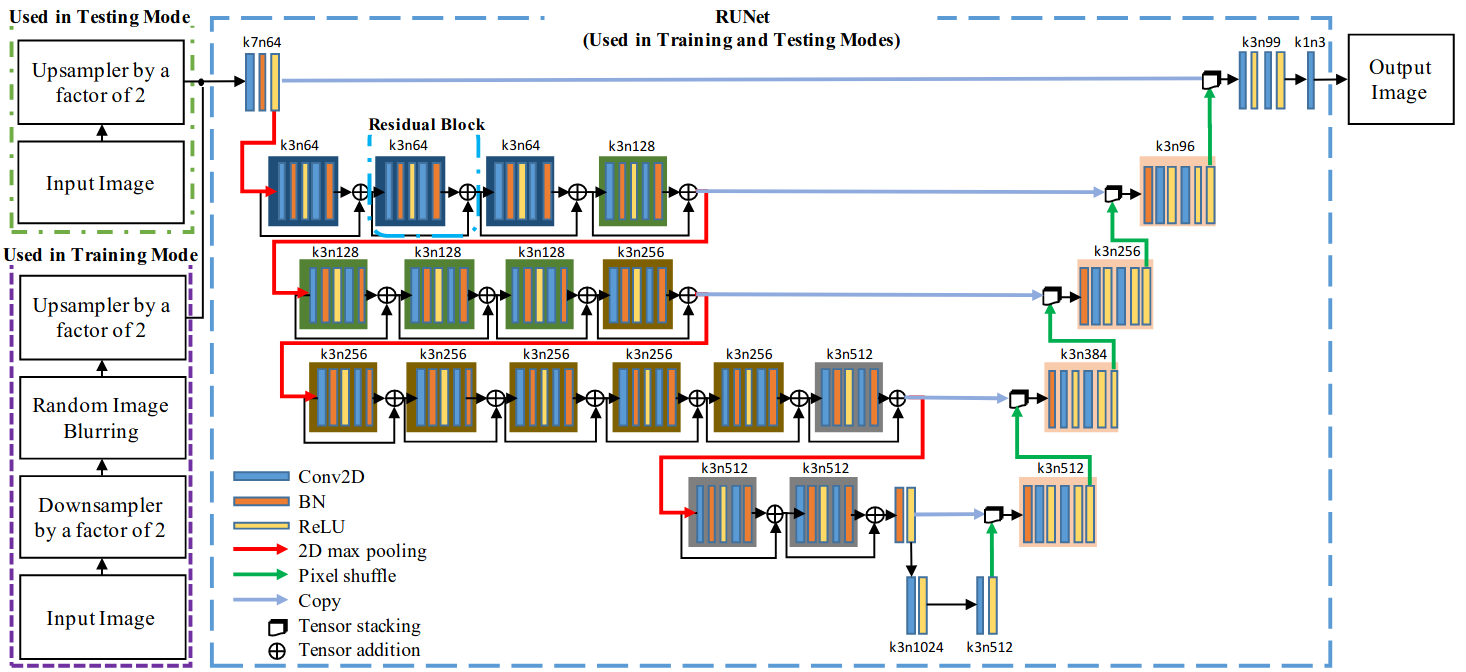

## Implementación

De manera general se realiza el siguiente proceso

1. Se obtienen parches de las imágenes de entrenamiento, en total 10000 parches. Se obtienen aleatoreamente con ventanas de tamaño 32x32
2. Los parches obtenidos forman nuestro *y_train*
3. *x_train* es obtenido al redimensionar cada parche de 32x32 a 16x16. Así la primer capa de la red se encarga de duplicar cada parche de entrada de 16x16 a 32x32. Dado que se incrementa el tamaño al doble y se pierde información, la red se encargará de aprender las caracteristicas de los parches de tal forma que el parche de entrada de 16x16 convertido a 32x32 sea reconstruido lo más parecido posible a su correspondiente parche original en *y_train*. Así la red entrenada duplicará el tamaño de las imágenes de tal manera que la información faltante sea reconstruida.
4. Los pesos de la red entrenada para los parches de tamaño 16x16 se usaran para generar otra red similar solo que la entrada y salida será de imágenes de tamaño 512x512 y 1024x1024 correspondientemente. Así la información obtenida de los parches será usada para duplicar el tamaño de imágenes 512x512 a 1024x1024.

Importamos las bibliotecas necesarias

In [0]:
import time

from os import listdir

import cv2
import numpy as np

from tensorflow.image import resize as tf_resize_image

from tensorflow.compat.v1.keras.backend import get_session
from tensorflow.compat.v1.keras import backend as tf
from tensorflow.keras import models
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, \
                         BatchNormalization, ReLU, Lambda, Concatenate, Add, \
                         UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model

import matplotlib.pyplot as plt

## Carga de los datos

In [0]:
# Only for google drive descomentar si los datos estan en google drive

# from google.colab import drive
# drive.mount('/gdrive')

# path = "/gdrive/My Drive/2do Semestre/Machine Learning/Tarea 4/"
# file_name = path + "Base de datos.zip"

# !unzip "$file_name"


# file_name = path + "images_test"
# !unzip "$file_name"

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
Archive:  /gdrive/My Drive/2do Semestre/Machine Learning/Tarea 4/Base de datos.zip
replace Base de datos/im15.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
Archive:  /gdrive/My Drive/2do Semestre/Machine Learning/Tarea 4/images_test.zip
replace images_test/im1.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [0]:
# Obtenemos los nombres de las imágenes en el directorio

path = "Base de datos"
images_names = listdir(path)
print("Número de imágenes: %d" % len(images_names))

Número de imágenes: 53


## Generar los parches y construir el dataset de entrenamiento

In [0]:
# Leemos cada imagen que usaremos para el entrenamiento
images = [cv2.imread(path + '/' + f_name) for f_name in images_names]

Funciones para obtener slices(parches) de las imágenes

In [0]:
def get_slices(images, quantity=10000, size=(32, 32)):
    """ Return random slices from the images
        
        Args:
            images (iterator): Images to slice
            quantity (int): Number of total slice
            size: (tuple(int, int)): Slice size
        
        Returns:
            Generator(): A random slice with dimensions size
    """
    for k in np.random.randint(0, len(images), quantity):
        h, w, _ = images[k].shape
        max_h = h - size[0]
        max_w = w - size[1]
        x = np.random.randint(0, max_w, 1)[0]
        y = np.random.randint(0, max_h, 1)[0]
        yield images[k][y:y+size[0], x:x+size[1]]


def build_dataset(images, training_size=10000, slice_size=(32,32), slice_sample=(16,16)):
    """ Builds and returns a training set with random slices from the given images.

        Args:
            training_size (int): Training set size
            slice_size (tupple(int, int)): Slice size
            slice_sample (tuple(int, int)): Size of a sample from a slice

        Returns:
            tuple(x_train, y_train):
                x_train: Sample of each generated slice with dimensions 'slice_sample
                y_train: Slice generated from the images with dimensions 'slice_size'
    """
    slices = get_slices(images, quantity=training_size)
    def _resample(img):
        return cv2.resize(img, slice_sample, interpolation=cv2.INTER_LINEAR)
    y_train = list(slices)
    x_train = [_resample(img) for img in y_train]

    return np.array(x_train, dtype=np.float64)/255.0, np.array(y_train, dtype=np.float64)/255.0

Construimos el conjunto de entrenamiento *x_train* constituido de 10000 parches de 16x61 obtenidos de las imágenes muestreados de parches más grandes de 32x32.
*y_train* contiene los correspondientes parches de 32x32.

In [0]:
x_train, y_train = build_dataset(images,
                                 training_size=10000,
                                 slice_size=(32, 32),
                                 slice_sample=(16, 16))

x_train.shape, y_train.shape

((10000, 16, 16, 3), (10000, 32, 32, 3))

In [0]:
y_train[0].shape, x_train[0].shape

((32, 32, 3), (16, 16, 3))

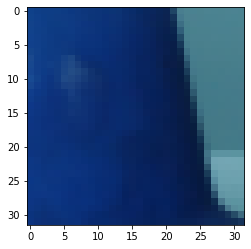

In [0]:
plt.imshow(y_train[2])

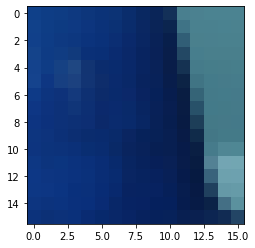

In [0]:
plt.imshow(x_train[2])

## Construcción de la Red Neuronal

Los bloques del artículo [A_Robust_UNet_Architecture_for_Image_Super-Resolution](http://openaccess.thecvf.com/content_CVPRW_2019/papers/WiCV/Hu_RUNet_A_Robust_UNet_Architecture_for_Image_Super-Resolution_CVPRW_2019_paper.pdf)

In [0]:
def generic_block(x, kernel_size=(3,3), filters=64, residual_block=True):
    """ Return a generic block from the original arquitecture """
    x_i = x
    x = Conv2D(filters=filters, kernel_size=kernel_size, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Conv2D(filters=filters, kernel_size=kernel_size, padding='same')(x)
    x = BatchNormalization()(x)
    if residual_block:
        x = Add()([x_i, x])
    return x


def blue_block(x, residual_block=True):
    """ Returns a blue block from the diagram """
    return generic_block(x, kernel_size=(3,3), filters=64, residual_block=residual_block)


def green_block(x, residual_block=True):
    """ Returns a green block from the diagram """
    return generic_block(x, kernel_size=(3,3), filters=128, residual_block=residual_block)


def brown_block(x, residual_block=True):
    """ Returns a brown block from the diagram """
    return generic_block(x, kernel_size=(3,3), filters=256, residual_block=residual_block)


def gray_block(x, residual_block=True):
    """ Returns a gray block from the diagram """
    return generic_block(x, kernel_size=(3,3), filters=512, residual_block=residual_block)


def orange_block(x, kernel_size=(3,3), filters=None):
    """ Returns a orange block from the diagram """
    x = BatchNormalization()(x)
    x = Conv2D(filters=filters, kernel_size=kernel_size, padding='same', activation='relu')(x)
    x = Conv2D(filters=filters, kernel_size=kernel_size, padding='same', activation='relu')(x)
    x = ReLU()(x)
    return x


def init_block(x, kernel_size=(7,7), filters=64):
    """ Returns a initial block from the diagram """
    x = Conv2D(filters=filters, kernel_size=kernel_size, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    return x


def last_block(x, kernel_size=(3,3), filters=99):
    """ Returns a last block from the diagram """
    x = Conv2D(filters=filters, kernel_size=kernel_size, padding='same', activation='relu')(x)
    x = Conv2D(filters=filters, kernel_size=kernel_size, padding='same', activation='relu')(x)
    return x


def input_block(x_shape, reshape=(32, 32)):
    """ Resize the input to the dimensions 'reshape' """
    x_input = Input(shape=x_shape)
    x = Lambda(lambda img: tf_resize_image(img, reshape))(x_input)
    return x_input, x


def output_block(x, kernel_size=(1,1), filters=3):
    """ Apply a simple Conv2D layer """
    x = Conv2D(filters=filters, kernel_size=kernel_size, padding='same')(x)
    return x


def conv2D_relu_block(x, kernel_size=(3,3), filters=1024):
    """ Apply a simple Conv2D layer with relu activation """
    return Conv2D(filters=filters, kernel_size=kernel_size, padding='same', activation='relu')(x)


def BN_relu_block(x):
    """ Apply a batch normalization and a relu activation """
    x = BatchNormalization()(x)
    x = ReLU()(x)
    return x


def copy_up_concatenate(x1, x2, up_size=(2, 2)):
    """ Apply a UpSampling to x2 by 2x2 factor and concatenate the result with x1 """
    x2 = UpSampling2D(size=up_size, interpolation='bilinear')(x2)
    return Concatenate()([x1, x2])


Construimos la Unet sin los bloques residuales, como entrada recibe un parche de dimensiones 16x16, la primer capa se encarga de hacer un reshape de 32x32, por tanto el error se estimará de este reshape de 32x32 con el parche original de 32x32

In [0]:
def build_UNET(input_shape, to_size=(32, 32), residual_block=False):
    x_in, u0 = input_block(input_shape, reshape=to_size)
    
    u0 = init_block(u0)

    u1 = MaxPooling2D(pool_size=(2, 2))(u0)
    u1 = blue_block(u1, residual_block=residual_block)
    u1 = blue_block(u1, residual_block=residual_block)
    u1 = blue_block(u1, residual_block=residual_block)
    u1 = green_block(u1, residual_block=False)

    u2 = MaxPooling2D(pool_size=(2, 2))(u1)
    u2 = green_block(u2, residual_block=residual_block)
    u2 = green_block(u2, residual_block=residual_block)
    u2 = green_block(u2, residual_block=residual_block)
    u2 = brown_block(u2, residual_block=False)
    
    u3 = MaxPooling2D(pool_size=(2, 2))(u2)
    u3 = brown_block(u3, residual_block=residual_block)
    u3 = brown_block(u3, residual_block=residual_block)
    u3 = brown_block(u3, residual_block=residual_block)
    u3 = brown_block(u3, residual_block=residual_block)
    u3 = brown_block(u3, residual_block=residual_block)
    u3 = gray_block(u3, residual_block=False)

    u4 = MaxPooling2D(pool_size=(2, 2))(u3)
    u4 = gray_block(u4, residual_block=residual_block)
    u4 = gray_block(u4, residual_block=residual_block)
    u4 = BN_relu_block(u4)

    u5 = conv2D_relu_block(u4, kernel_size=(3,3), filters=1024)
    u5 = conv2D_relu_block(u5, kernel_size=(3,3), filters=512)

    up1 = copy_up_concatenate(u4, u5, up_size=(1, 1))
    up1 = orange_block(up1, kernel_size=(3,3), filters=512)

    up2 = copy_up_concatenate(u3, up1)
    up2 = orange_block(up2, kernel_size=(3,3), filters=384)

    up3 = copy_up_concatenate(u2, up2)
    up3 = orange_block(up3, kernel_size=(3,3), filters=256)

    up4 = copy_up_concatenate(u1, up3)
    up4 = orange_block(up4, kernel_size=(3,3), filters=96)

    up5 = copy_up_concatenate(u0, up4)

    u6 = last_block(up5)
    u6 = output_block(u6)

    x_out = u6
    
    return x_in, x_out


### Creamos y compilamos el modelo sin bloques residuales

In [0]:
tf.clear_session() # To reset all, (weights)

x_in, y_out = build_UNET(x_train[0].shape, to_size=(32,32), residual_block=False)

mymodel = Model(inputs=[x_in],
                outputs=[y_out],
                name='multiOut')

mymodel.compile(optimizer='rmsprop',
                loss='mse',
                metrics=['acc'])

In [0]:
# mymodel.summary()

In [0]:
# plot_model(mymodel, to_file='model.png', show_shapes=True, show_layer_names=True)

#### Entrenamiento del modelo sin bloques residuales

In [0]:
tic=time.time()
history = mymodel.fit(x=x_train,
                      y=y_train,
                      validation_split=0.2,
                      epochs=50,
                      shuffle=True,
                      batch_size=128,
                      verbose=2)

print('Tiempo: {} secs'.format(time.time()-tic))

Epoch 1/50
63/63 - 19s - loss: 16.0497 - acc: 0.5888 - val_loss: 0.0594 - val_acc: 0.6014
Epoch 2/50
63/63 - 19s - loss: 0.0193 - acc: 0.6727 - val_loss: 0.1169 - val_acc: 0.4795
Epoch 3/50
63/63 - 19s - loss: 0.0289 - acc: 0.6678 - val_loss: 1111404.1250 - val_acc: 0.4183
Epoch 4/50
63/63 - 19s - loss: 0.0165 - acc: 0.7092 - val_loss: 221.6834 - val_acc: 0.6628
Epoch 5/50
63/63 - 19s - loss: 0.0110 - acc: 0.7425 - val_loss: 0.1551 - val_acc: 0.7030
Epoch 6/50
63/63 - 19s - loss: 0.0073 - acc: 0.7620 - val_loss: 0.0112 - val_acc: 0.7515
Epoch 7/50
63/63 - 19s - loss: 0.0058 - acc: 0.7709 - val_loss: 0.0190 - val_acc: 0.5473
Epoch 8/50
63/63 - 19s - loss: 0.0054 - acc: 0.7875 - val_loss: 0.0064 - val_acc: 0.7968
Epoch 9/50
63/63 - 19s - loss: 0.0046 - acc: 0.7804 - val_loss: 0.0098 - val_acc: 0.7548
Epoch 10/50
63/63 - 19s - loss: 0.0045 - acc: 0.7802 - val_loss: 0.0052 - val_acc: 0.7954
Epoch 11/50
63/63 - 19s - loss: 0.0038 - acc: 0.7878 - val_loss: 0.0146 - val_acc: 0.7981
Epoch 12/5

Guardamos los pesos del modelo

In [0]:
m1_weights = mymodel.get_weights()
# mymodel.save_weights('model_no_residual')

#### Metricas de la función de costo y accuracy

In [0]:
def plot_loss_metric(history):
    loss_values = history.history['loss']
    val_loss_values = history.history['val_loss']
    epochs = range(1, len(loss_values) + 1)

    plt.figure(figsize=(12,5))
    plt.plot(epochs, loss_values, 'b', label='Training loss')
    plt.plot(epochs, val_loss_values, 'g', label='Validation loss')
    plt.title('Valor de la función objetivo (loss) en conjuntos de en entrenamiento y validación')
    plt.xlabel('Epocas')
    plt.ylabel('loss')
    plt.legend()

    plt.show()


def plot_accuracy_metric(history):
    acc_values = history.history['acc']
    val_acc_values = history.history['val_acc']
    epochs = range(1, len(acc_values) + 1)

    plt.figure(figsize=(12,5))
    plt.plot(epochs, acc_values, 'b', label='Accuracy')
    plt.plot(epochs, val_acc_values, 'g', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('accuracy')
    plt.legend()

    plt.show()


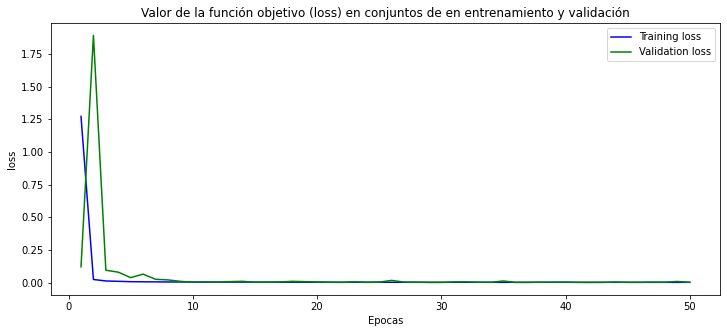

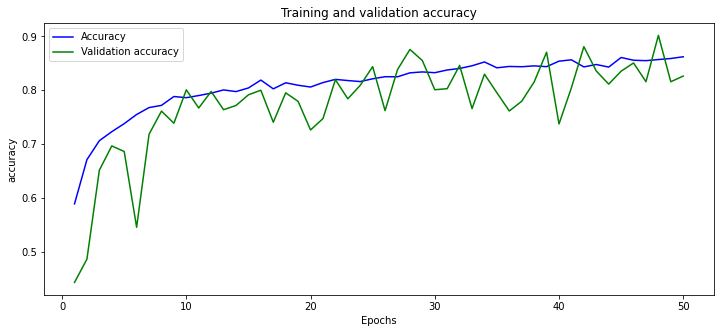

In [0]:
plot_loss_metric(history)
plot_accuracy_metric(history)

### Creamos y compilamos el modelo con bloques residuales


In [0]:
tf.clear_session() # To reset all, (weights)

x_in, y_out = build_UNET(x_train[0].shape, to_size=(32,32), residual_block=True)

mymodel = Model(inputs=[x_in],
                outputs=[y_out],
                name='multiOut')

mymodel.compile(optimizer='rmsprop',
                loss='mse',
                metrics=['acc'])

#### Entrenamiento del modelo con bloques residuales

In [0]:
tic=time.time()
history = mymodel.fit(x=x_train,
                      y=y_train,
                      validation_split=0.2,
                      epochs=50,
                      shuffle=True,
                      batch_size=128,
                      verbose=2)

print('Tiempo: {} secs'.format(time.time()-tic))


mymodel.save_weights('model_residual')
m2_weights = mymodel.get_weights()

Epoch 1/50
63/63 - 20s - loss: 1.2714 - acc: 0.5894 - val_loss: 0.1202 - val_acc: 0.4437
Epoch 2/50
63/63 - 19s - loss: 0.0236 - acc: 0.6713 - val_loss: 1.8918 - val_acc: 0.4869
Epoch 3/50
63/63 - 19s - loss: 0.0122 - acc: 0.7065 - val_loss: 0.0943 - val_acc: 0.6518
Epoch 4/50
63/63 - 19s - loss: 0.0096 - acc: 0.7232 - val_loss: 0.0794 - val_acc: 0.6968
Epoch 5/50
63/63 - 19s - loss: 0.0067 - acc: 0.7381 - val_loss: 0.0377 - val_acc: 0.6864
Epoch 6/50
63/63 - 19s - loss: 0.0059 - acc: 0.7550 - val_loss: 0.0645 - val_acc: 0.5460
Epoch 7/50
63/63 - 19s - loss: 0.0052 - acc: 0.7679 - val_loss: 0.0251 - val_acc: 0.7184
Epoch 8/50
63/63 - 19s - loss: 0.0044 - acc: 0.7720 - val_loss: 0.0203 - val_acc: 0.7613
Epoch 9/50
63/63 - 19s - loss: 0.0043 - acc: 0.7884 - val_loss: 0.0094 - val_acc: 0.7389
Epoch 10/50
63/63 - 19s - loss: 0.0039 - acc: 0.7862 - val_loss: 0.0030 - val_acc: 0.8007
Epoch 11/50
63/63 - 19s - loss: 0.0036 - acc: 0.7902 - val_loss: 0.0053 - val_acc: 0.7671
Epoch 12/50
63/63 -

#### Metricas de la función de costo y accuracy

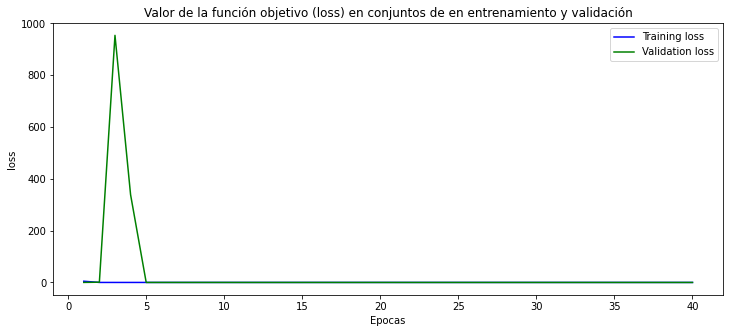

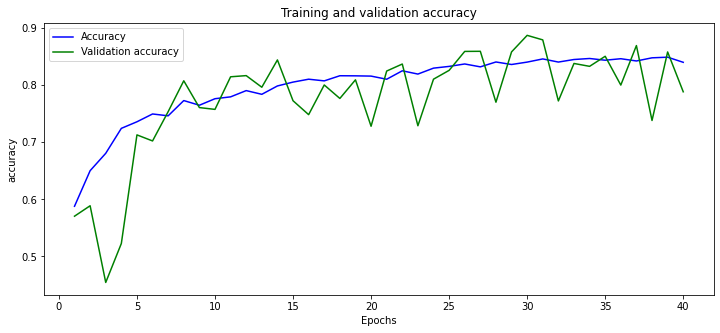

In [0]:
plot_loss_metric(history)
plot_accuracy_metric(history)

## Test con nuevas imágenes

### Lectura de las imágenes de prueba

In [0]:
# Obtenemos los nombres de las imágenes
path = "images_test"
images_names = listdir(path)
images_names

['im3.png', 'im1.png', 'im2.png', 'im0.png']

In [0]:
def read_image(f_name, size):
    """ Read a image and returns it with the dimension 'size' """
    img = cv2.imread(path + '/' + f_name)
    img = cv2.resize(img, size, interpolation=cv2.INTER_LINEAR)
    return img


def resize_img_with_loss(img, size, loss_factor=2):
    """ Change the size of an image with information loss"""
    loss_size = (int(size[0]/loss_factor), int(size[1]/loss_factor))
    # img = cv2.resize(img, loss_size, interpolation=cv2.INTER_LINEAR)
    img = cv2.resize(img, size, interpolation=cv2.INTER_LINEAR)
    return np.array(img, dtype=np.float64) / 255

Elegimos una imagen para prueba

In [0]:
img_num = 0
img_ori = read_image(images_names[img_num], (1024,1024))
img_loss = resize_img_with_loss(img_ori, (512, 512), loss_factor=2)

In [0]:
x_test = np.array([img_loss])

### Construccion del nuevo modelo con input de 512x512 y salida de la imágen de 1024x1024

#### Predicción con Unet

In [0]:
tf.clear_session() # To reset all, (weights)
img_shape = (512, 512, 3)
x_in2, y_out2 = build_UNET(img_shape, to_size=(1024,1024), residual_block=False)

mymodel2 = Model(inputs=[x_in2],
                 outputs=[y_out2],
                 name='multiOut')

mymodel2.compile(optimizer='rmsprop',
                loss='mse',
                metrics=['acc'])


# mymodel2.load_weights('model_no_residual')
mymodel2.set_weights(m1_weights)
img_recov_1 = mymodel2.predict(x_test)

#### Predicción con Runet


In [0]:
tf.clear_session() # To reset all, (weights)
img_shape = (512, 512, 3)
x_in2, y_out2 = build_UNET(img_shape, to_size=(1024,1024), residual_block=True)

mymodel3 = Model(inputs=[x_in2],
                 outputs=[y_out2],
                 name='multiOut')

mymodel3.compile(optimizer='rmsprop',
                 loss='mse',
                 metrics=['acc'])

# mymodel3.load_weights('model_residual')
mymodel3.set_weights(m2_weights)
img_recov_2 = mymodel3.predict(x_test)

### Resultados y conclusiones

Dibujamos la imágen original, la rescalada a la mitad y la reconstrucción a través de la red

In [0]:
def display_images(images):
    w=10
    h=10
    fig=plt.figure(figsize=(20, 8))
    columns = 3
    rows = 1
    index = 0
    titles = ['Original', 'Rescalada', 'Salida de la UNet','Salida de la Red']
    for i in range(1, columns*rows + 1):
        img = images[index]
        ax = fig.add_subplot(rows, columns, i)
        ax.set_title('%s (%dx%d): ' % (titles[i-1], img.shape[0], img.shape[1]))
        # plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.imshow(img)
        index += 1
    plt.show()

Tamaños de las imágenes

In [0]:
print(img_ori.shape, img_loss.shape, img_recov_1.shape, img_recov_2.shape)

(1024, 1024, 3) (512, 512, 3) (1, 1024, 1024, 3) (1, 1024, 1024, 3)


#### Resultados de la Unet (sin bloques residuales)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


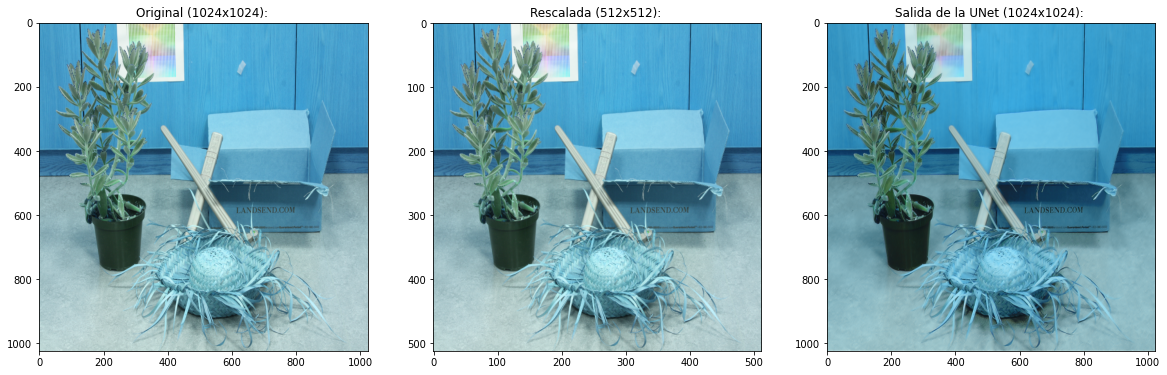

In [0]:
display_images([img_ori, img_loss, img_recov_1[0]])

#### Resultados de la RUnet (con bloques residuales)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


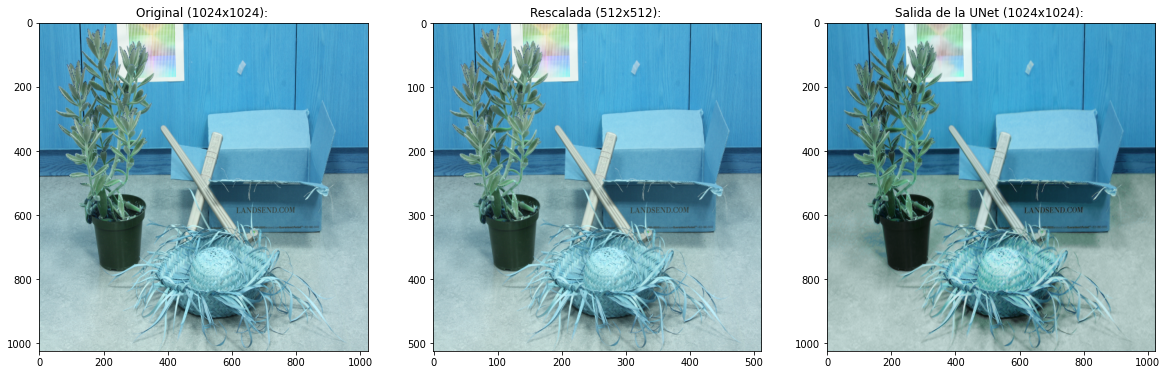

In [0]:
display_images([img_ori, img_loss, img_recov_2[0]])

#### Resultados de la Unet (sin bloques residuales) - Zoom

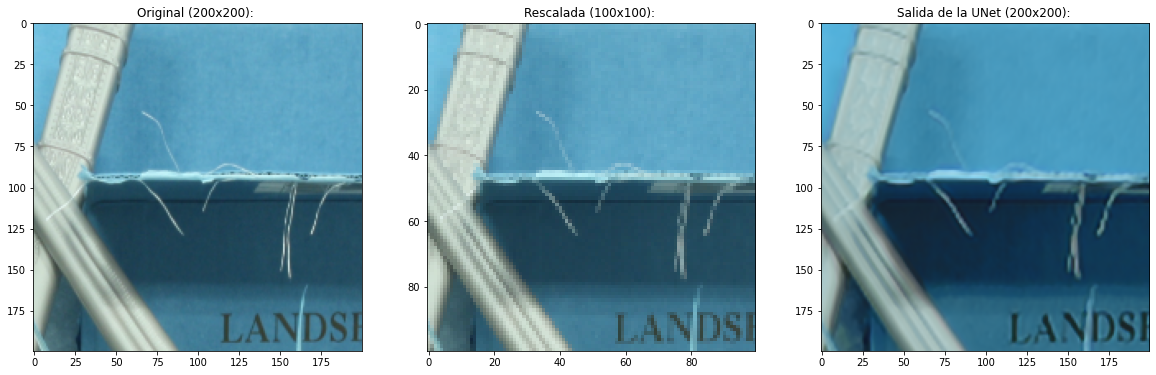

In [0]:
display_images([img_ori[400:600,500:700], img_loss[200:300,250:350], img_recov_1[0][400:600,500:700]])

La primer imágen corresponde a la imágen original de 1024x1024, la de enmedio es la imágen reducida en un factor de 2 (512x512) y la última corresponde al resultado de la red con la imagen reducida de 512x512 como input generando una del doble de tamaño (1024x1024).

Se puede observar un pixeleado sobre la imágen rescalada a 512x512 sobre la misma sección. El resultado de la red dichos dientes de sierra han desaparecido conservando mejor la estructura de los objetos de la imágen (podemos notarlo mucho mejor en las letras), aún así se alcanza a percibir una especie de suavizado en el resultado, mostrándolo no tan definida los límites de cada objeto. 

También la imágen resultante los colores son obscurecidos agregando un poco más de contraste entre ellos, perdiendo así el color real, pareciera que las letras de la salida de la red son mejor resaltadas pero es el fenómeno del contraste del color más negro de las mismas con el fondo azul.


#### Resultados de la RUnet (con bloques residuales) - Zoom

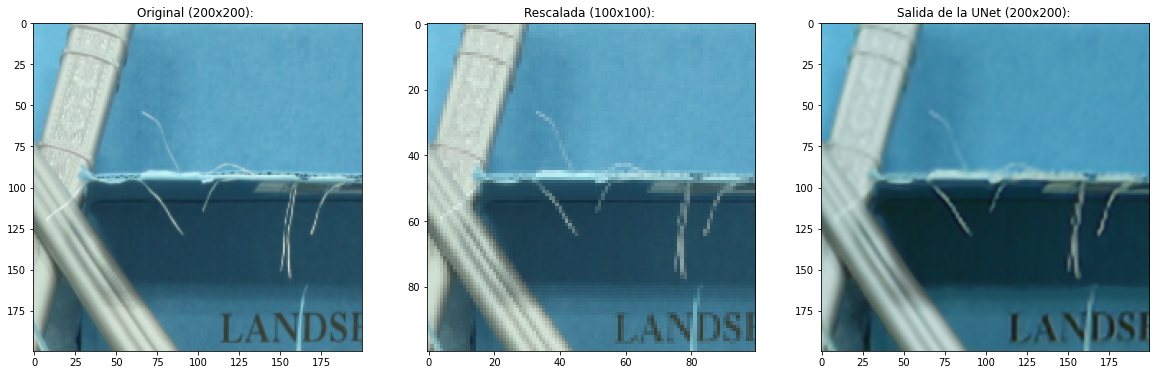

In [0]:
display_images([img_ori[400:600,500:700], img_loss[200:300,250:350], img_recov_2[0][400:600,500:700]])

Al igual que la anterior La primer imágen corresponde a la imágen original de 1024x1024, la de enmedio es la imágen reducida en un factor de 2 (512x512) y la última corresponde al resultado de la red con la imagen reducida de 512x512 como input generando una del doble de tamaño (1024x1024).
 
Al contrario de la anterior la imágen no es tan obscurecida, los colores son más parecidos a la original, se logra percibir mejor en el color de las letras, las cuales son mucho mpas parecida a las originales. Tambien podemos notar que los grabados de en los palos mostrados en la imágen son mucho más distinguibles.


En general en ambos métodos se obtuvieron buenos resultados, apesar de obtener parches de tan solo 50 imágenes, en este experimento parece ser que la retroalimentación de los bloques residuales ayuda a mantener mucho mejor el color de los elementos. Entrenando la red con un conjunto de datos mucho más diverso lo más probable es que los resultados mejoren.
